# Meridional Heat Transport (MHT)
This notebook calculates the model MHT from the MOM5 diagnostic `temp_yflux_adv_int_z`. To use this notebook, we need to ensure this diagnostic is available in the model output. We can check if a variable is available using `cc.querying.get_variables()` function from the COSIMA cookbook.  
  
Note that currently this notebook calculates the total (all basins) MHT and it also includes comparisons to a few observational products.

## Loading relevant libraries

In [1]:
#Accessing the COSIMA database
import cosima_cookbook as cc

#Manipulating and analysing data
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr

#Regular expressions (regex) to extract information from strings
import re

#Plotting figures
import matplotlib.pyplot as plt
#Shows graph in notebook
%matplotlib inline

## Loading model data

We will use the COSIMA cookbook to search its database and load `temp_yflux_adv_int_z` to start our calculations. To do this we will need to do the following:
1. Start a COSIMA cookbook session
2. Define the model configuration of interest
3. Define the experiment of interest
4. Define the diagnostic (variable) of interest

**NOTE:** If you are in doubt about the models, experiments and diagnostics available in the database, check the [Cookbook Tutorial]("../Tutorials/COSIMA_CookBook_Tutorial.ipynb") for more information.

In [2]:
#Start a COSIMA cookbook session
session = cc.database.create_session()

#Define experiment of interest
expt = '025deg_jra55v13_iaf_gmredi6'

We are now ready to query the database and load the data to start our analysis. We load `temp_yflux_adv_int_z`. For this example, we have chosen to use 6 years of output.

In [3]:
mht = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session, n=3)
mht

<xarray.DataArray 'temp_yflux_adv_int_z' (time: 72, yu_ocean: 1080,
                                          xt_ocean: 1440)>
dask.array<concatenate, shape=(72, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * time      (time) datetime64[ns] 2198-01-14T12:00:00 ... 2203-12-14T12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
Attributes:
    long_name:      z-integral of cp*rho*dxt*v*temp
    units:          Watts
    valid_range:    [-1.e+18  1.e+18]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_c
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_i...

Viewing the variable containing our data provides a number of key information, including:
- *Shape of dataset* - In this case the data includes 72 time steps, 1080 steps along the y axis and 1440 along the x axis.
- *Name of coordinates* - Our data includes `time`, `yu_ocean` (i.e., latitude), and `xt_ocean` (i.e., longitude).
- *Values included under each coordinate* - We can see that `time` includes monthly values from 2198-01-14 to 2203-12-14.
- *Metadata* - This information is included under `Attributes` and it includes things like units.

## Calculating mean and converting units
From the metadata, we can see that our dataset is in Watts (W), so we will convert them to petawatts (PW)

In [4]:
#We transform units from watts to petawatts
mht = mht * 1e-15
mht = mht.assign_attrs(units='PettaWatts')
mht

<xarray.DataArray 'temp_yflux_adv_int_z' (time: 72, yu_ocean: 1080,
                                          xt_ocean: 1440)>
dask.array<mul, shape=(72, 1080, 1440), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * time      (time) datetime64[ns] 2198-01-14T12:00:00 ... 2203-12-14T12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
Attributes:
    units:    PettaWatts

and then we calculate the mean across the `time` dimension.

In [5]:
#We calculate the mean across all timesteps
mht = mht.mean('time')

#Finally, we sum up all values across each longitude
mht_xsum = mht.sum('xt_ocean')
mht_xsum

<xarray.DataArray 'temp_yflux_adv_int_z' (yu_ocean: 1080)>
dask.array<sum-aggregate, shape=(1080,), dtype=float32, chunksize=(540,), chunktype=numpy.ndarray>
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0

## Comparison between model output and observations
Before producing our figure, we will compare the model output with observations to check the model accuracy.

### Read ERBE Period Ocean and Atmospheric Heat Transport
Observations are also available in Gadi, here we show how to load them to our notebook.

In [6]:
#Path to the file containing observations
filename = '/g/data3/hh5/tmp/cosima/observations/original/MHT/obs_vq_am_estimates.txt'

#Creating empty variables to store our observations
erbe_mht = []
erbe_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
    #Open each line from rows 1 to 96
    for line in f.readlines()[1:96]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting latitude and MHT and saving to empty variables
        erbe_lat.append(float(sline[0]))
        erbe_mht.append(float(sline[3]))

#Checking MHT variables
erbe_mht

[7.82256e-05,
 -0.00548183,
 -0.00534277,
 -0.00778958,
 -0.0153764,
 -0.0189109,
 -0.0172473,
 -0.0321044,
 -0.0647783,
 -0.104008,
 -0.129806,
 -0.202605,
 -0.297446,
 -0.374377,
 -0.424618,
 -0.464923,
 -0.508466,
 -0.544651,
 -0.56517,
 -0.575634,
 -0.563567,
 -0.51931,
 -0.45106,
 -0.377069,
 -0.310393,
 -0.271679,
 -0.279999,
 -0.329881,
 -0.39744,
 -0.464742,
 -0.515384,
 -0.565431,
 -0.620221,
 -0.678495,
 -0.736833,
 -0.790937,
 -0.843637,
 -0.90752,
 -0.984516,
 -1.05272,
 -1.0956,
 -1.10212,
 -1.05218,
 -0.93882,
 -0.761357,
 -0.502307,
 -0.155427,
 0.253559,
 0.666604,
 1.00846,
 1.25254,
 1.42962,
 1.57235,
 1.69269,
 1.78862,
 1.84355,
 1.85095,
 1.82898,
 1.79722,
 1.76105,
 1.71365,
 1.65596,
 1.59826,
 1.53441,
 1.45553,
 1.34517,
 1.20096,
 1.03473,
 0.856831,
 0.704894,
 0.62273,
 0.602973,
 0.60382,
 0.602437,
 0.599438,
 0.588678,
 0.573292,
 0.5557,
 0.518399,
 0.46073,
 0.40554,
 0.361088,
 0.328643,
 0.303888,
 0.271855,
 0.232879,
 0.18562,
 0.146825,
 0.110927

### Read NCEP and ECMWF Oceanic and Atmospheric Transport Products

In [7]:
#Path to the file containing observations
filename = '/g/data3/hh5/tmp/cosima/observations/original/MHT/ANNUAL_TRANSPORTS_1985_1989.ascii'

#Creating empty variables to store our observations
ncep_g_mht = []
ecwmf_g_mht = []
ncep_g_err = []
ecwmf_g_err = []
ncep_a_mht = []
ecwmf_a_mht = []
ncep_a_err = []
ecwmf_a_err = []
ncep_p_mht = []
ecwmf_p_mht = []
ncep_p_err = []
ecwmf_p_err = []
ncep_i_mht = []
ecwmf_i_mht = []
ncep_i_err = []
ecwmf_i_err = []
ncep_ip_mht = []
ecwmf_ip_mht = []
ncep_ip_err = []
ecwmf_ip_err = []
o_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
#Open each line in file (ignoring the first row)
    for line in f.readlines()[1:]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting values and saving to correct variable defined above
        o_lat.append(float(sline[0])*0.01)  # T42 latitudes (north to south)
        ncep_g_mht.append(float(sline[4])*0.01) # Residual Ocean Transport - NCEP
        ecwmf_g_mht.append(float(sline[5])*0.01)# Residual Ocean Transport - ECWMF
        ncep_a_mht.append(float(sline[7])*0.01)# Atlantic Ocean Basin Transport - NCEP
        ncep_p_mht.append(float(sline[8])*0.01)# Pacific Ocean Basin Transport - NCEP
        ncep_i_mht.append(float(sline[9])*0.01)# Indian Ocean Basin Transport - NCEP
        ncep_g_err.append(float(sline[10])*0.01)# Error Bars for NCEP Total Transports
        ncep_a_err.append(float(sline[11])*0.01)# Error Bars for NCEP Atlantic Transports 
        ncep_p_err.append(float(sline[12])*0.01)# Error Bars for NCEP Pacific Transports 
        ncep_i_err.append(float(sline[13])*0.01)# Error Bars for NCEP Indian Transports 
        ecwmf_a_mht.append(float(sline[15])*0.01)# Atlantic Ocean Basin Transport - ECWMF
        ecwmf_p_mht.append(float(sline[16])*0.01)# Pacific Ocean Basin Transport - ECWMF
        ecwmf_i_mht.append(float(sline[17])*0.01)# Indian Ocean Basin Transport - ECWMF
        ecwmf_g_err.append(float(sline[18])*0.01)# Error Bars for ECWMF Total Transports
        ecwmf_a_err.append(float(sline[19])*0.01)# Error Bars for NCEP Atlantic Transports
        ecwmf_p_err.append(float(sline[20])*0.01)# Error Bars for NCEP Pacific Transports
        ecwmf_i_err.append(float(sline[21])*0.01)# Error Bars for NCEP Indian Transports

#Calculating MHT
ncep_ip_mht = [a+b for a, b in zip(ncep_p_mht,ncep_i_mht)]
ecwmf_ip_mht = [a+b for a, b in zip(ecwmf_p_mht,ecwmf_i_mht)]
ncep_ip_err = [max(a,b) for a, b in zip(ncep_p_err,ncep_i_err)]
ecwmf_ip_err = [max(a,b) for a, b in zip(ecwmf_p_err,ecwmf_i_err)]

## Plotting model outputs against observations

We plot the global meridional heat transport as calculated from model outputs (blue line) and observations.

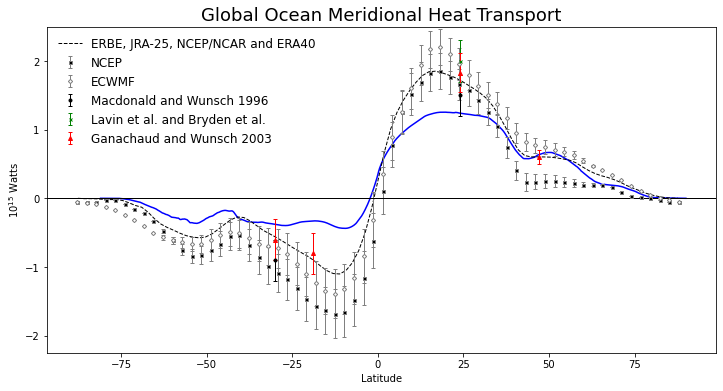

In [8]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

#Plotting model outputs
mht_xsum.plot(ax = ax, color="blue", label="")

#Adding observations and error bars for observations
ax.plot(erbe_lat, erbe_mht, 'k--', linewidth=1, label="ERBE, JRA-25, NCEP/NCAR and ERA40")
plt.errorbar(o_lat[::-1], ncep_g_mht[::-1], yerr=ncep_g_err[::-1], c='gray', fmt='s', 
             markerfacecolor='k', markersize=3, capsize=2, linewidth=1, label="NCEP")
plt.errorbar(o_lat[::-1], ecwmf_g_mht[::-1], yerr=ecwmf_g_err[::-1], c='gray', fmt='D', 
             markerfacecolor='white', markersize=3, capsize=2, linewidth=1, label="ECWMF")
plt.errorbar(24, 1.5, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1, 
             label="Macdonald and Wunsch 1996")
plt.errorbar(-30, -0.9, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1)
plt.errorbar(24, 2.0, yerr=0.3, fmt='x', c='green', markersize=3, capsize=2, linewidth=1, 
             label="Lavin et al. and Bryden et al.")
plt.errorbar(24, 1.83, yerr=0.28, fmt='^', c='red', markersize=4, capsize=2, linewidth=1, 
             label="Ganachaud and Wunsch 2003")
plt.errorbar(-30, -0.6, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar(-19, -0.8, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar(47, 0.6, yerr=0.1, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)

#Adding legend
plt.legend(frameon=False, fontsize=12)
plt.axhline(y=0, linewidth=1, color='black')

#Defining plot limits along the y axis
plt.ylim(-2.25, 2.5)

#Adding titles for figure and axes
plt.title('Global Ocean Meridional Heat Transport', fontsize=18)
plt.xlabel('Latitude')
plt.ylabel('$10^{15}$ Watts');